In [1]:
import os

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from keras_unet.metrics import iou, iou_thresholded, dice_coef

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [2]:
os.chdir('..')

In [3]:
from model.img_generator import DataGenerator2D
from model.metric_utils import calculate_iou_df,  calculate_iou 
from model.loss_functions import jaccard_distance_loss, focal_loss, dice_coef_loss, binary_focal_loss

# Check how a given trained model predicts

Load `cancer_pixels_df` (This assumes you have already executed the `main.py --mode train`)

In [4]:
holdout_df_pkl_path_dir = os.path.join('preprocessed_dataframes', 'holdout_fold_0_df_cancer_info.pkl')
tr_df_pkl_path_dir = os.path.join('preprocessed_dataframes', 'tr_fold_0_df_cancer_info.pkl')


model_path = './best_performing_model/model_sampling.17-0.09.h5'
model_resize_dims = (128, 128)
loss_fn = binary_focal_loss(gamma=2., alpha=0.7)
prediction_batch_size = 32
pixel_threshold = 0.0875

In [5]:
tr_fold_0_df = pd.read_pickle(tr_df_pkl_path_dir)
tr_fold_0_df.head()

x_tr_img_path  depth  \
index depth_i                                                             
005   0        ml4h_proj1_colon_cancer_ct\imagesTr\colon_005....     98   
      1        ml4h_proj1_colon_cancer_ct\imagesTr\colon_005....     98   
      2        ml4h_proj1_colon_cancer_ct\imagesTr\colon_005....     98   
      3        ml4h_proj1_colon_cancer_ct\imagesTr\colon_005....     98   
      4        ml4h_proj1_colon_cancer_ct\imagesTr\colon_005....     98   

                                                   y_tr_img_path  \
index depth_i                                                      
005   0        ml4h_proj1_colon_cancer_ct\labelsTr\colon_005....   
      1        ml4h_proj1_colon_cancer_ct\labelsTr\colon_005....   
      2        ml4h_proj1_colon_cancer_ct\labelsTr\colon_005....   
      3        ml4h_proj1_colon_cancer_ct\labelsTr\colon_005....   
      4        ml4h_proj1_colon_cancer_ct\labelsTr\colon_005....   

               cancer_pixel_area  has_cancer_pixels  
index depth_i                                        
005   0                      0.0              False  
      1                      0.0              False  
      2                      0.0              False  
      3                      0.0              False  
      4                      0.0              False

In [6]:
holdout_fold_0_df = pd.read_pickle(holdout_df_pkl_path_dir)
holdout_fold_0_df.head()

x_tr_img_path  depth  \
index depth_i                                                             
001   0        ml4h_proj1_colon_cancer_ct\imagesTr\colon_001....     60   
      1        ml4h_proj1_colon_cancer_ct\imagesTr\colon_001....     60   
      2        ml4h_proj1_colon_cancer_ct\imagesTr\colon_001....     60   
      3        ml4h_proj1_colon_cancer_ct\imagesTr\colon_001....     60   
      4        ml4h_proj1_colon_cancer_ct\imagesTr\colon_001....     60   

                                                   y_tr_img_path  \
index depth_i                                                      
001   0        ml4h_proj1_colon_cancer_ct\labelsTr\colon_001....   
      1        ml4h_proj1_colon_cancer_ct\labelsTr\colon_001....   
      2        ml4h_proj1_colon_cancer_ct\labelsTr\colon_001....   
      3        ml4h_proj1_colon_cancer_ct\labelsTr\colon_001....   
      4        ml4h_proj1_colon_cancer_ct\labelsTr\colon_001....   

               cancer_pixel_area  has_cancer_pixels  
index depth_i                                        
001   0                      0.0              False  
      1                      0.0              False  
      2                      0.0              False  
      3                      0.0              False  
      4                      0.0              False

Load model

In [7]:
model = model = tf.keras.models.load_model(
    model_path,
    custom_objects={'iou':iou, 'iou_thresholded': iou_thresholded,
                    'binary_focal_loss_fixed': loss_fn})

### Predictions on holdout 

In [8]:
batch_size = 4
batches_to_see = 2

In [9]:
img_with_cancer_gen = DataGenerator2D(df=holdout_fold_0_df[holdout_fold_0_df.cancer_pixel_area > 0].sample(20),
                                      x_col='x_tr_img_path', y_col='y_tr_img_path', batch_size=batch_size,
                                      shuffle=False, resize_dim=model_resize_dims)

img_without_cancer_gen = DataGenerator2D(df=holdout_fold_0_df[holdout_fold_0_df.cancer_pixel_area == 0].sample(20),
                                         x_col='x_tr_img_path', y_col='y_tr_img_path', batch_size=batch_size,
                                         num_classes=None, shuffle=False, resize_dim=model_resize_dims)

X: (4, 128, 128)
y: (4, 128, 128)
(4, 128, 128, 1)


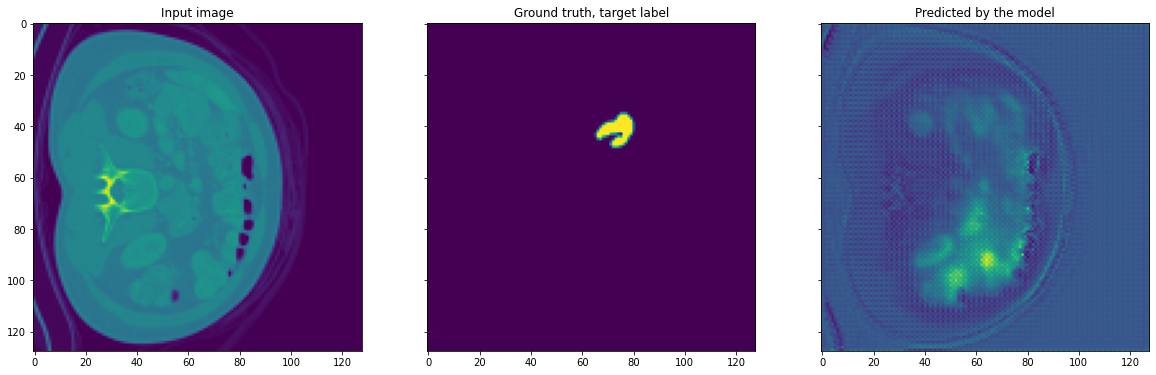

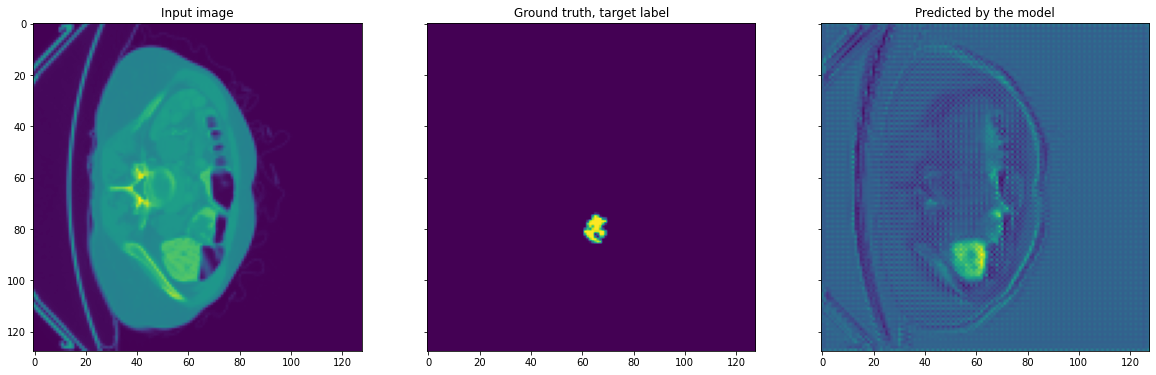

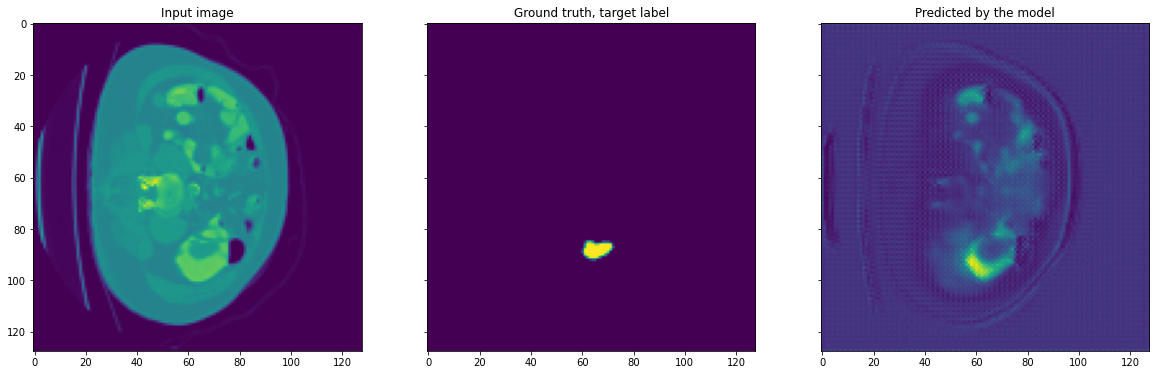

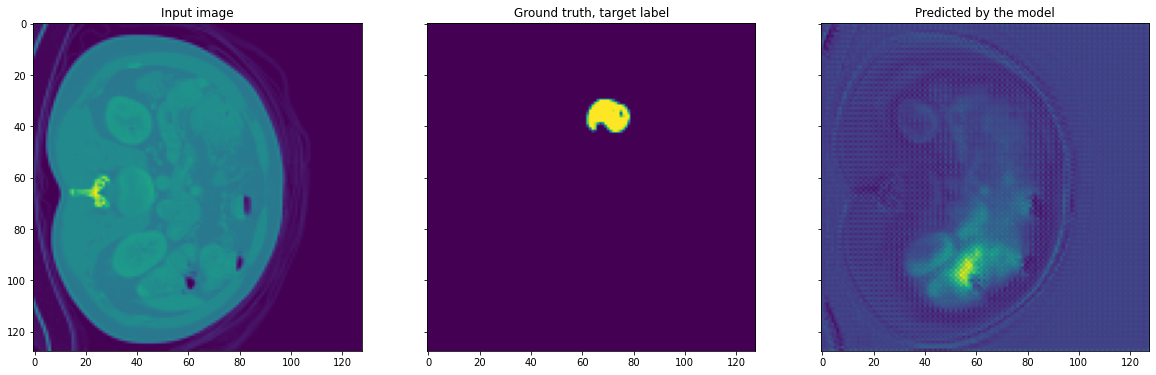

X: (4, 128, 128)
y: (4, 128, 128)
(4, 128, 128, 1)


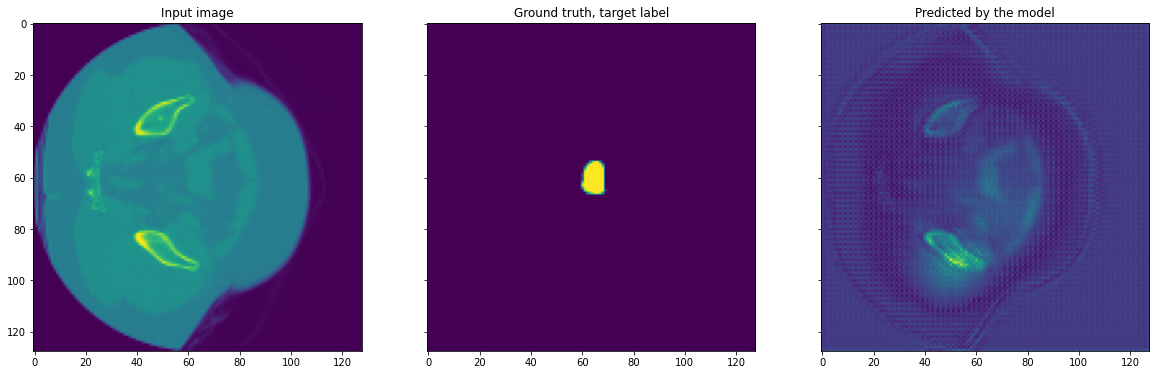

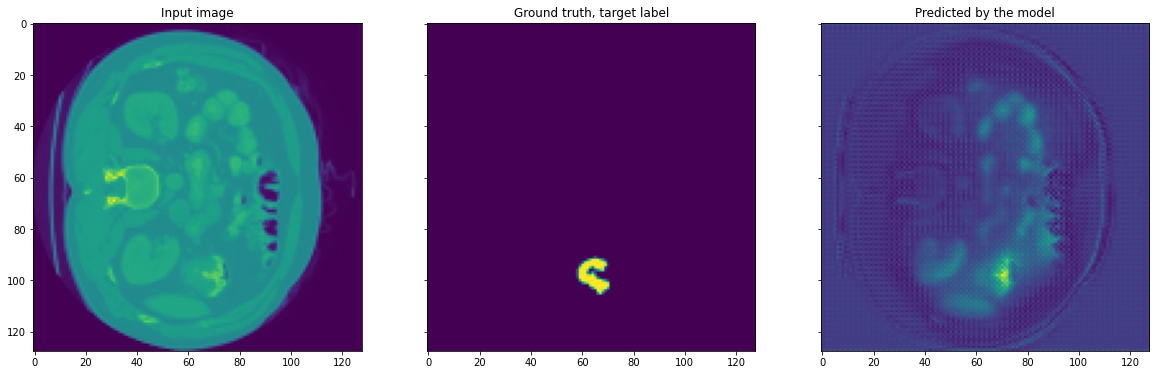

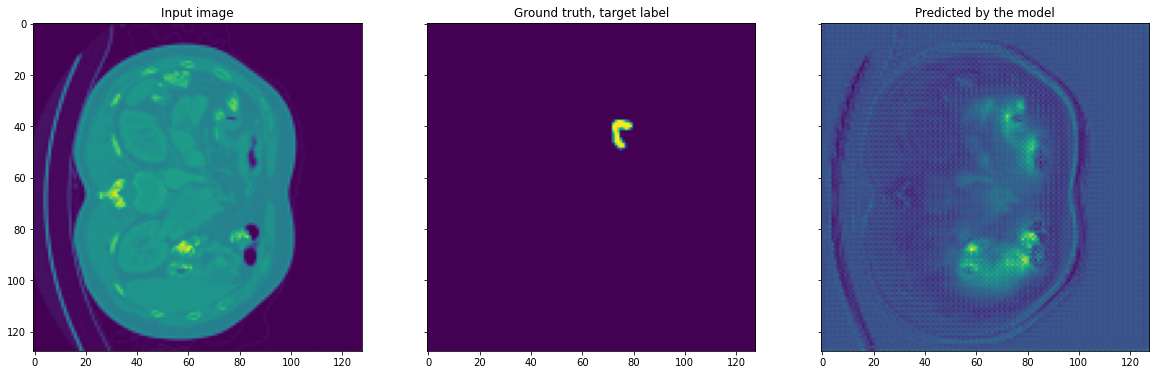

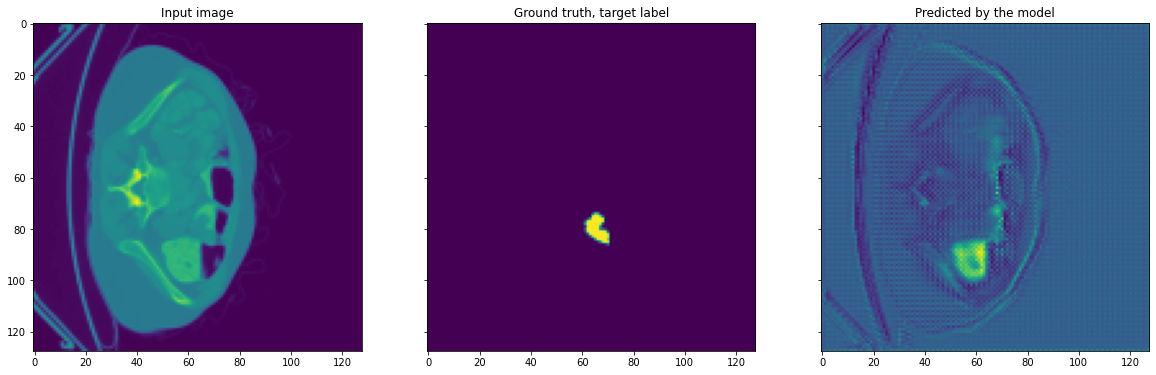

In [10]:
# Let's see how it predicts for images of cancer
for i, (X, y) in enumerate((img_with_cancer_gen)):
    print(f'X: {X.shape}')
    print(f'y: {y.shape}')

    y_pred = model.predict(X)
    print(y_pred.shape)
    
    for j in range(X.shape[0]):
        f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
        f.set_size_inches(20,20)

        ax1.imshow(X[j,:,:])
        ax1.set_title('Input image')
        
        ax2.imshow(y[j,:,:])
        ax2.set_title('Ground truth, target label')

        ax3.imshow(np.squeeze(y_pred[j,:,:]))
        ax3.set_title('Predicted by the model')
        
        plt.show()
        plt.close()
    
    if i == batches_to_see - 1:
        break

X: (4, 128, 128)
y: (4, 128, 128)
(4, 128, 128, 1)


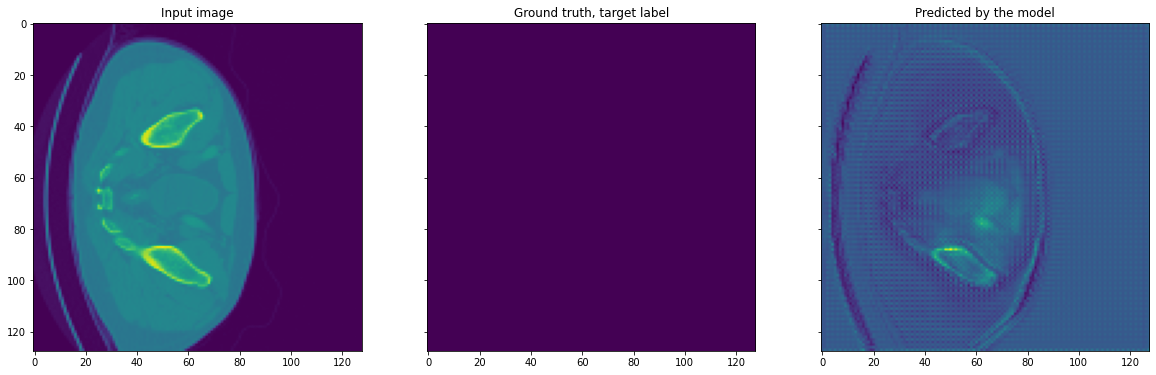

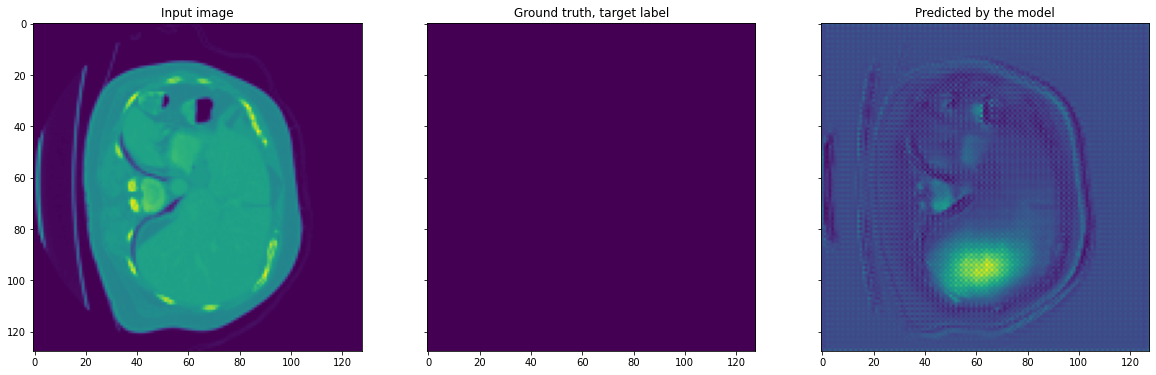

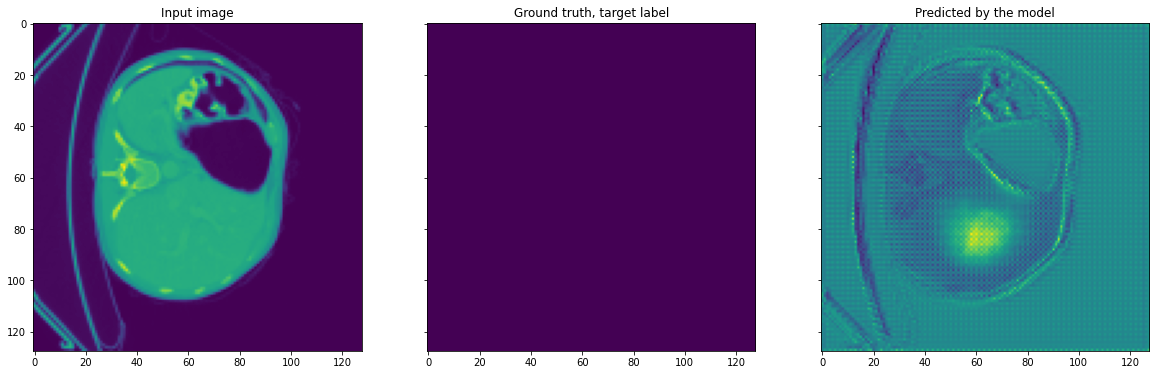

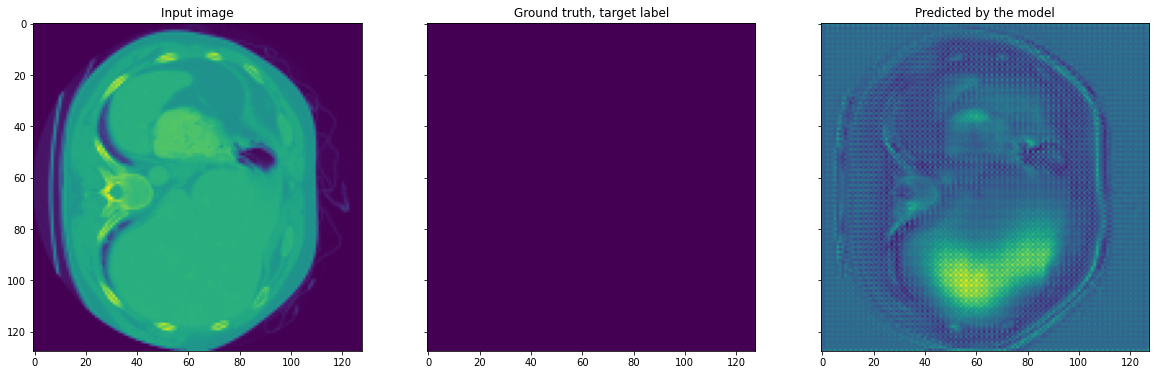

X: (4, 128, 128)
y: (4, 128, 128)
(4, 128, 128, 1)


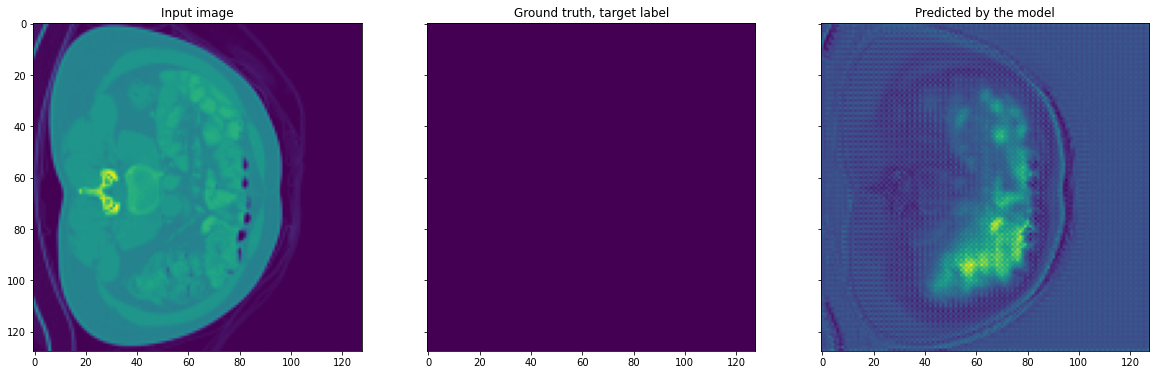

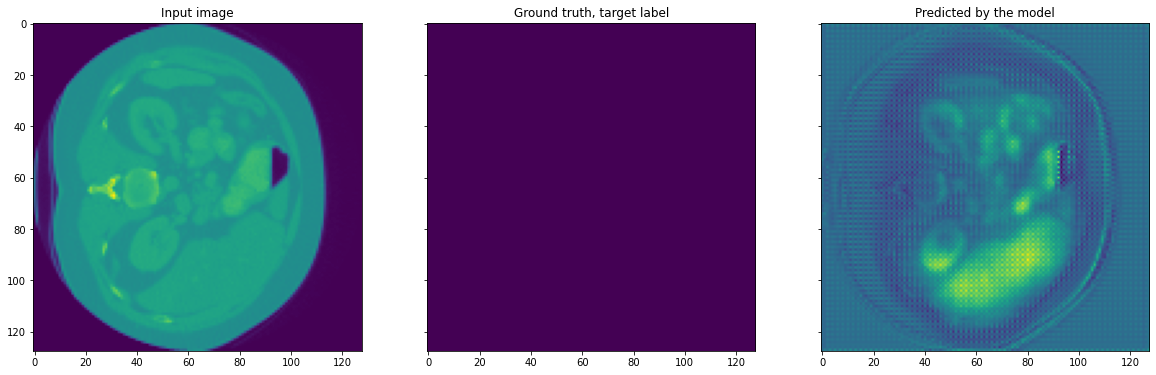

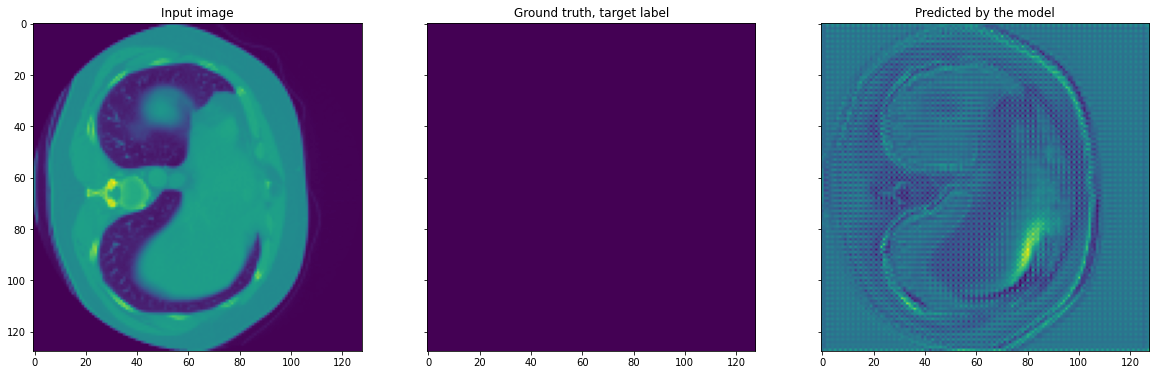

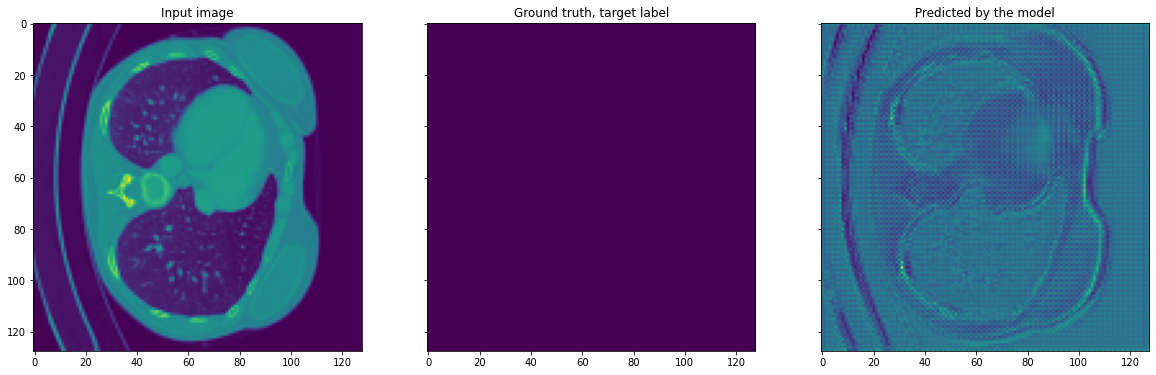

In [11]:
# Let's see how it predicts for images of cancer
for i, (X, y) in enumerate((img_without_cancer_gen)):
    print(f'X: {X.shape}')
    print(f'y: {y.shape}')

    y_pred = model.predict(X)
    print(y_pred.shape)
    
    for j in range(X.shape[0]):
        f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
        f.set_size_inches(20,20)

        ax1.imshow(X[j,:,:])
        ax1.set_title('Input image')
        
        ax2.imshow(y[j,:,:])
        ax2.set_title('Ground truth, target label')

        ax3.imshow(np.squeeze(y_pred[
            j,:,:]))
        ax3.set_title('Predicted by the model')
        
        plt.show()
        plt.close()
                
    if i == batches_to_see - 1:
        break

### Predictions on train 

In [12]:
img_with_cancer_gen = DataGenerator2D(df=tr_fold_0_df[tr_fold_0_df.cancer_pixel_area > 0].sample(20),
                                      x_col='x_tr_img_path', y_col='y_tr_img_path', 
                                      batch_size=batch_size, shuffle=False, resize_dim=model_resize_dims)

img_without_cancer_gen = DataGenerator2D(df=tr_fold_0_df[tr_fold_0_df.cancer_pixel_area==0].sample(20),
                                         x_col='x_tr_img_path', y_col='y_tr_img_path',
                                         batch_size=batch_size, num_classes=None, shuffle=False, resize_dim=model_resize_dims)

X: (4, 128, 128)
y: (4, 128, 128)
(4, 128, 128, 1)


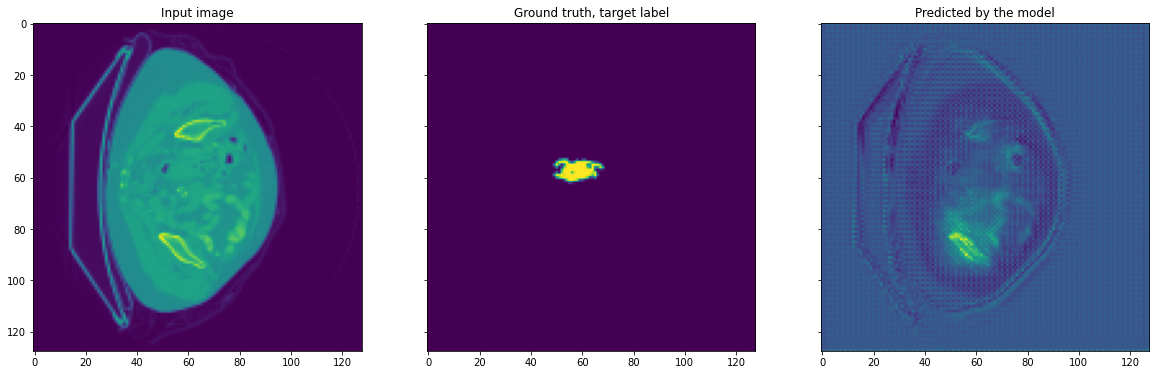

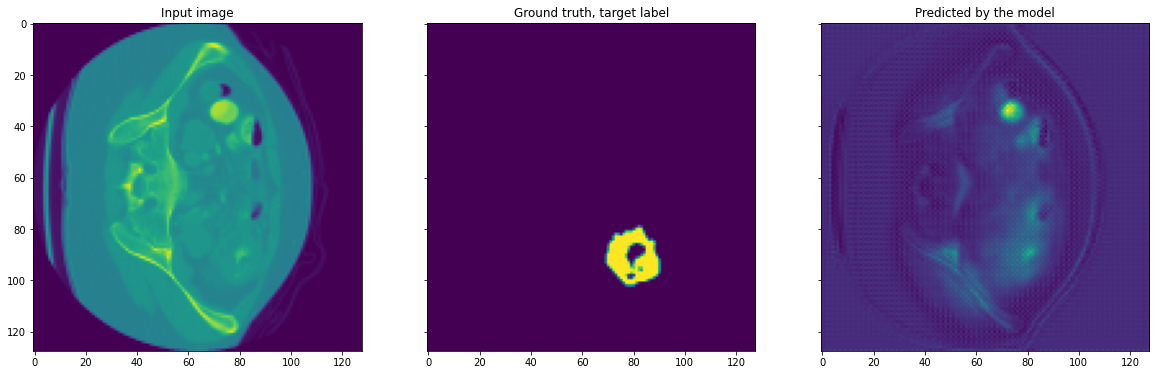

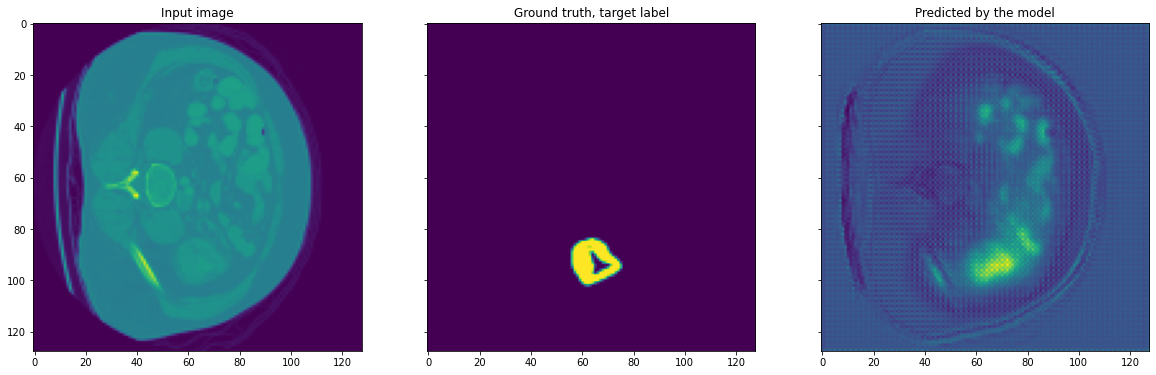

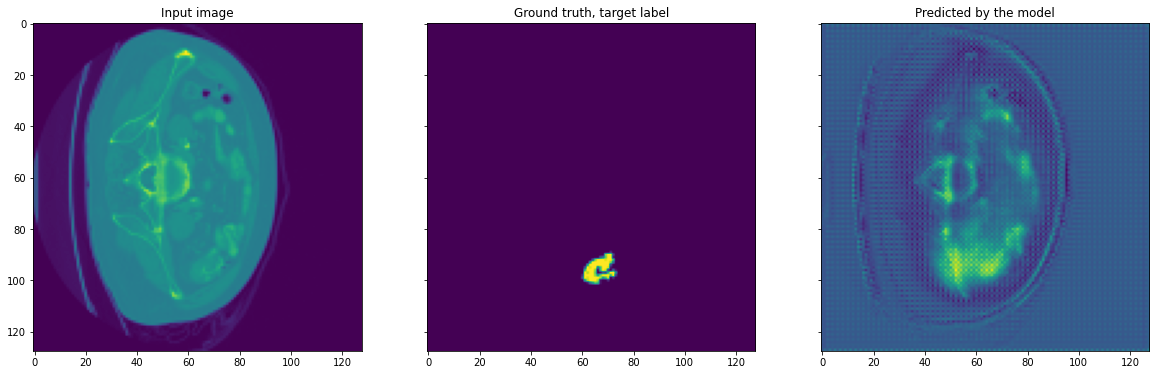

X: (4, 128, 128)
y: (4, 128, 128)
(4, 128, 128, 1)


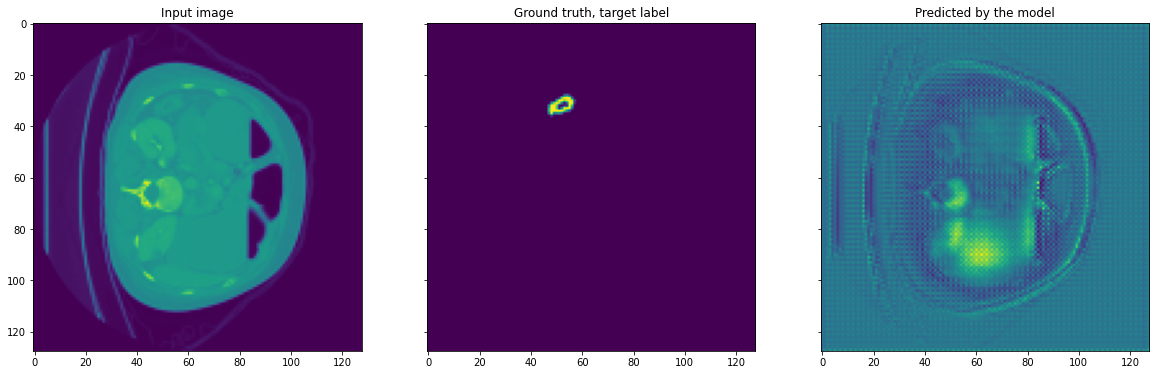

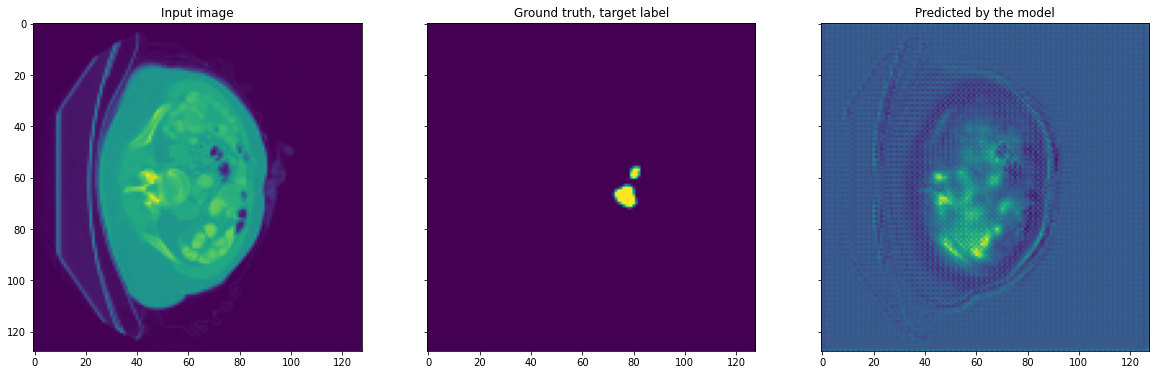

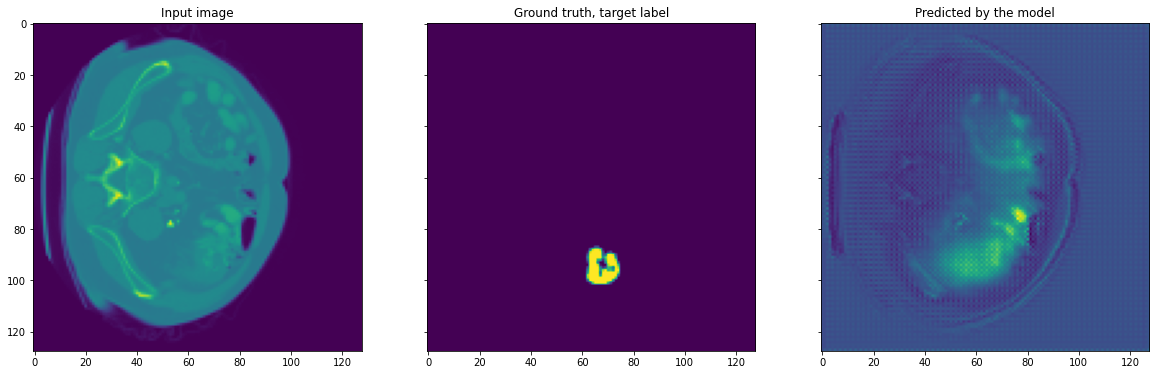

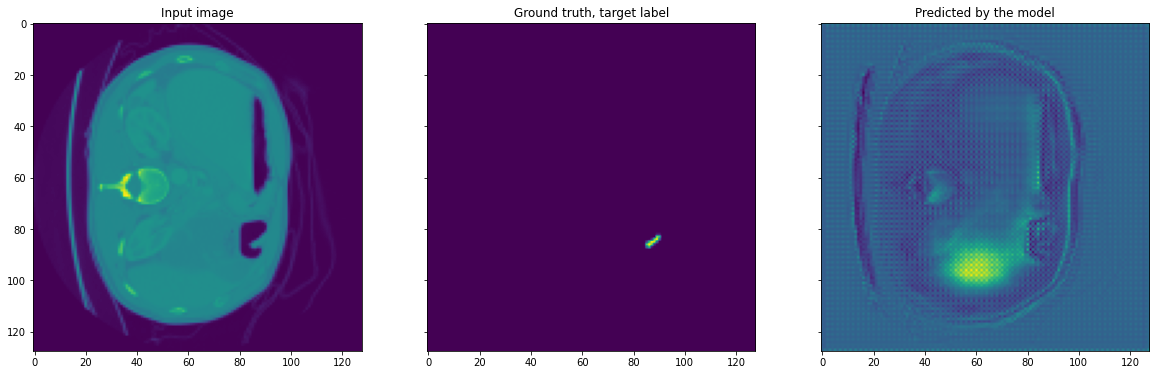

In [13]:
# Let's see how it predicts for images of cancer
for i, (X, y) in enumerate((img_with_cancer_gen)):
    print(f'X: {X.shape}')
    print(f'y: {y.shape}')

    y_pred = model.predict(X)
    print(y_pred.shape)
    
    for j in range(X.shape[0]):
        f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
        f.set_size_inches(20,20)

        ax1.imshow(X[j,:,:])
        ax1.set_title('Input image')
        
        ax2.imshow(y[j,:,:])
        ax2.set_title('Ground truth, target label')

        ax3.imshow(np.squeeze(y_pred[j,:,:]))
        ax3.set_title('Predicted by the model')
        
        plt.show()
        plt.close()
    
    if i == batches_to_see - 1:
        break

X: (4, 128, 128)
y: (4, 128, 128)
(4, 128, 128, 1)


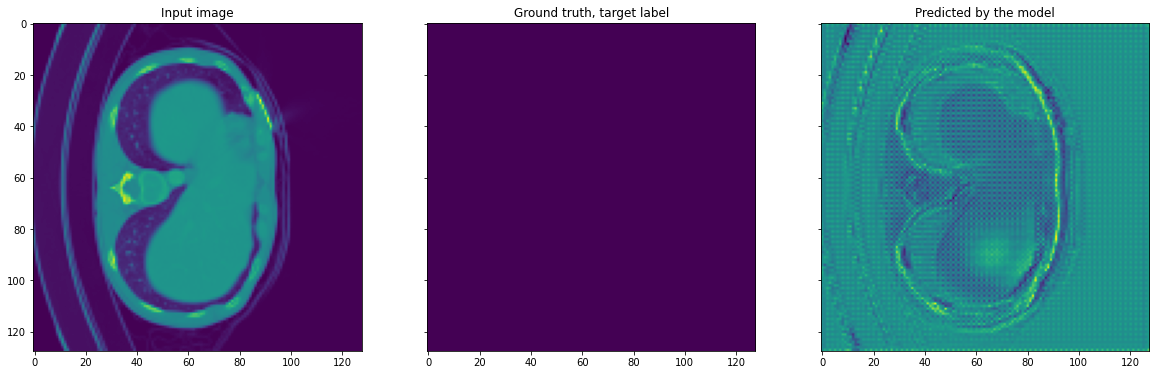

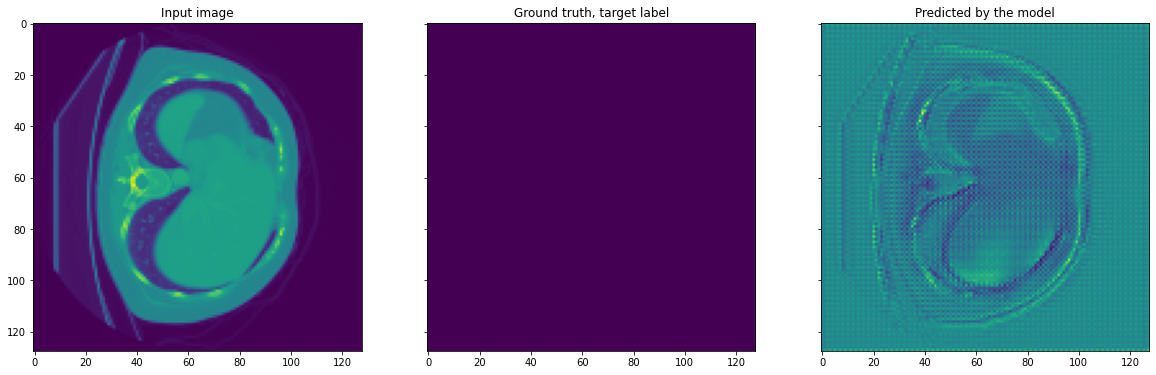

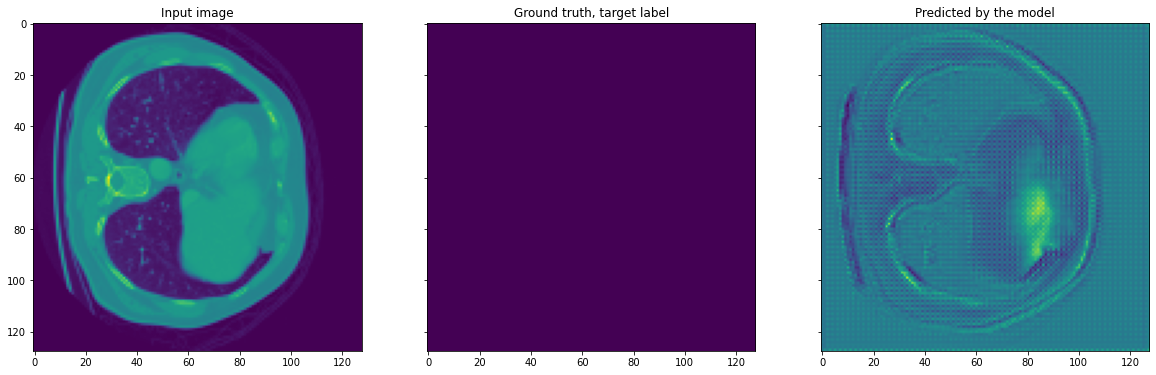

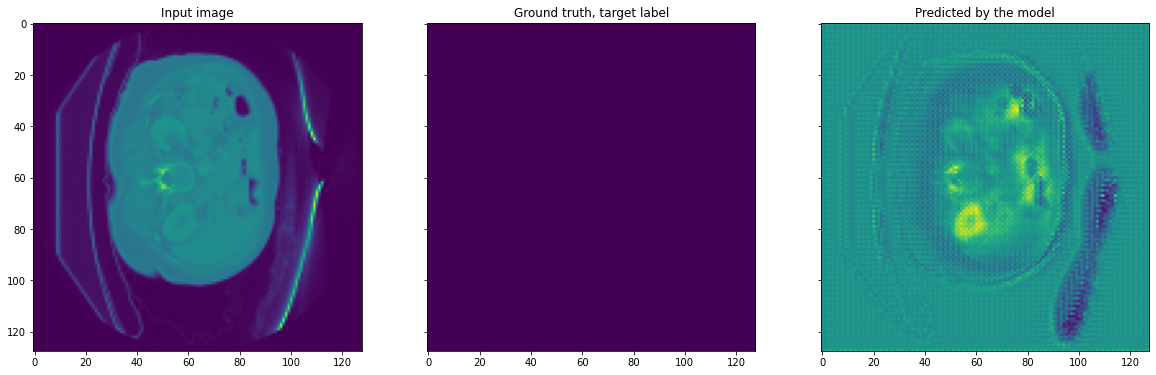

X: (4, 128, 128)
y: (4, 128, 128)
(4, 128, 128, 1)


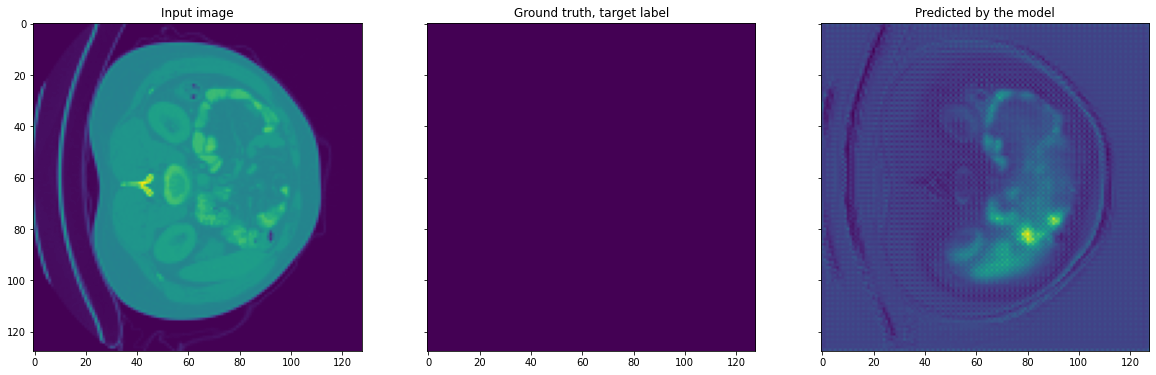

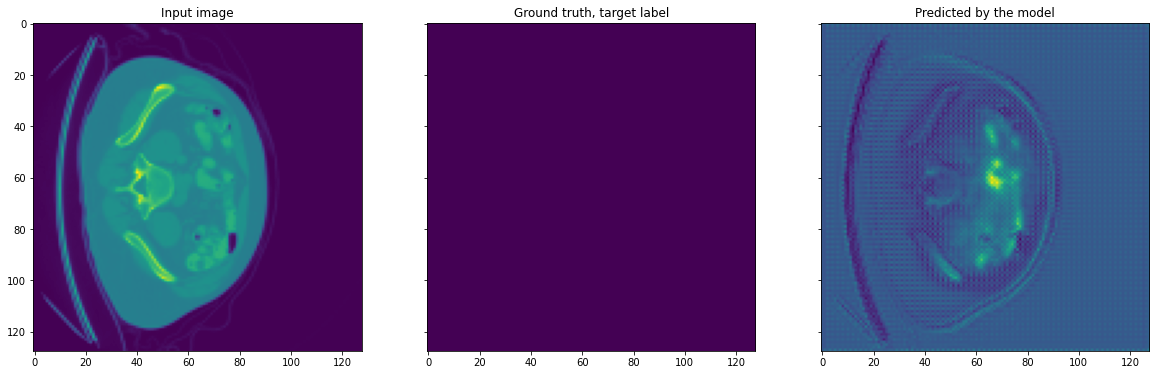

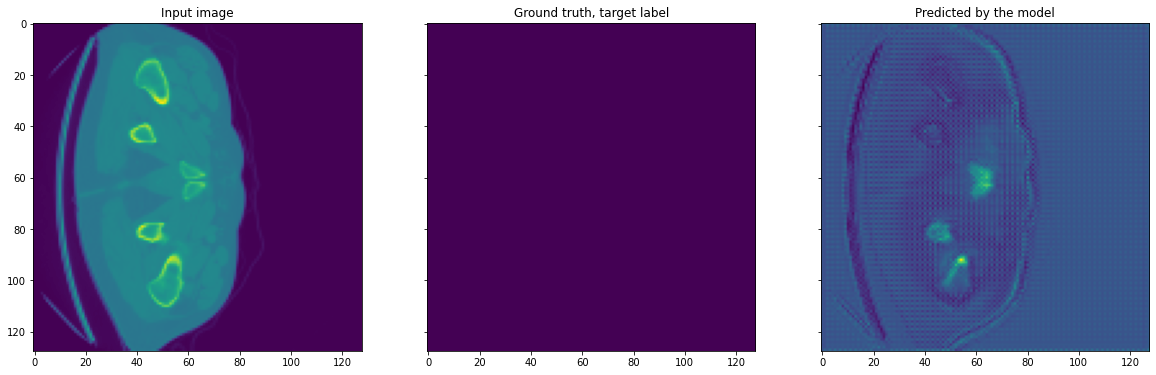

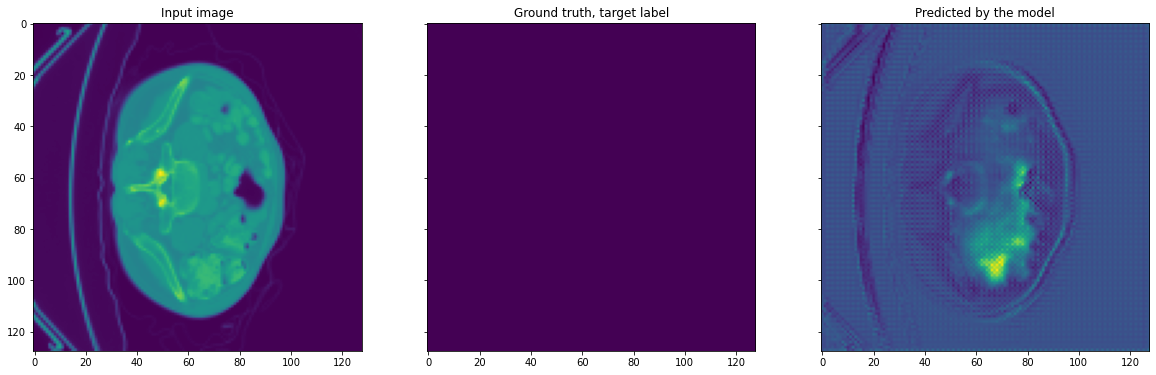

In [14]:
# Let's see how it predicts for images of cancer
for i, (X, y) in enumerate((img_without_cancer_gen)):
    print(f'X: {X.shape}')
    print(f'y: {y.shape}')

    y_pred = model.predict(X)
    print(y_pred.shape)
    
    for j in range(X.shape[0]):
        f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
        f.set_size_inches(20,20)

        ax1.imshow(X[j,:,:])
        ax1.set_title('Input image')
        
        ax2.imshow(y[j,:,:])
        ax2.set_title('Ground truth, target label')

        ax3.imshow(np.squeeze(y_pred[
            j,:,:]))
        ax3.set_title('Predicted by the model')
        
        plt.show()
        plt.close()
        
    if i == batches_to_see - 1:
        break
    